# Regularization

This notebook will have some problems related to lasso and ridge regression.

In [1]:
# import the packages we'll use
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("darkgrid")

## Theoretical Questions

##### 1. Deriving the Ridge Regression Estimator

Recall that finding the ridge regression coefficients involves minimizing the following:
$$
||y-X\beta||_2^2 + \alpha ||\beta||_2^2.
$$
But, this can be rewritten like so:
$$
(y-X\beta)^T(y-X\beta) + \alpha \beta^T \beta.
$$

Derive the estimate, $\hat{\beta}$ that minimizes this expression.

##### ANSWER

Expanding out $(y-X\beta)^T(y-X\beta) + \alpha \beta^T \beta$ gives $y^Ty - \beta^TX^Ty - y^TX\beta + \beta^T X^T X \beta + \alpha \beta^T \beta$, differentiating that with respect to $\beta$ and setting it equal to $0$ gives:

$$
0 = - X^Ty + X^TX\beta + \alpha \beta.
$$

Thus our estimate is

$$
\hat{\beta} = \left( X^TX + \alpha I \right)^{-1} X^T y.
$$



## Applied Questions

##### 1. 

Using the formula you derived in 1. under theoretical questions write some `numpy` code to fit a ridge regression model on the followinig data.

Load this data first.

In [2]:
## The Data
x_train = 3*(np.pi/2)*np.random.random(size=500) - 2*np.pi
y_train = np.sin(x_train) + .3*np.random.randn(500)

x_test = 3*(np.pi/2)*np.random.random(size=500) - 2*np.pi
y_test = np.sin(x_test) + .3*np.random.randn(500)

Use `PolynomialFeatures` to produce up to the $40^{\text{th}}$ power of `x` as your features matrix `X_train`. Then use `StandardScaler` to scale `X_train` prior to fitting the ridge regression.

In [3]:
## code here

from numpy.linalg import inv
from numpy import identity as I

def ridge_estimate(X,y,alpha):
    return inv(X.transpose().dot(X) + alpha*I(np.shape(X)[1])).dot(X.transpose().dot(y))

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler




In [4]:
## code here

alpha = 10

poly = PolynomialFeatures(degree = 40)
scaler = StandardScaler()

X_train = poly.fit_transform(x_train.reshape(-1,1))
X_train = scaler.fit_transform(X_train)

beta_hat = ridge_estimate(X_train,y_train,alpha)




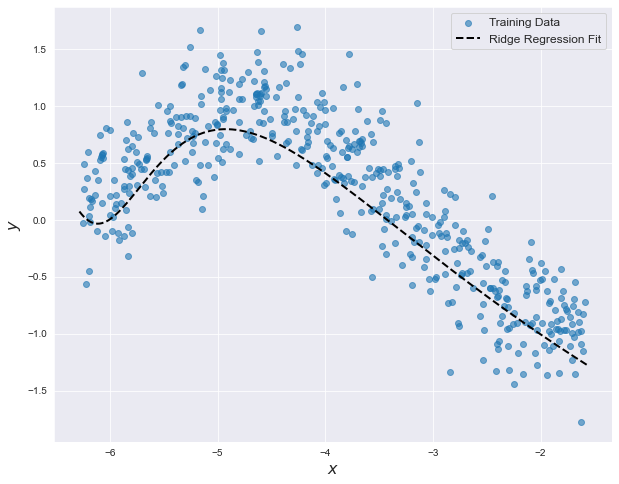

In [5]:
## code here

plt.figure(figsize=(10,8))

xs = 3*(np.pi/2)*np.linspace(0,1,500) - 2*np.pi
Xs = poly.transform(xs.reshape(-1,1))
Xs = scaler.transform(Xs)

plt.scatter(x_train,y_train,alpha=.6,label="Training Data")
plt.plot(xs,Xs.dot(beta_hat),'k--',linewidth=2,label="Ridge Regression Fit")

plt.xlabel("$x$",fontsize=16)
plt.ylabel("$y$",fontsize=16)
plt.legend(fontsize=12)

plt.show()




In [6]:
## code here






##### 2. The Elastic Net Algorithm

Elastic Net is a regularization regression algorithm that strives to set a middle ground between ridge regression and lasso. Here we set out to minimize:
$$
MSE + r\alpha ||\beta||_1 + \frac{1-r}{2}\alpha ||\beta||_2^2, \text{ for } r \in [0,1].
$$

$r$ is another hyperparameter, when $r=1$ we recover lasso regression. If $r=0$ we recover ridge.

First load in the `advertising.csv` data set below.

In [7]:
ads = pd.read_csv("../../../data/advertising.csv")
ads['sqrt_TV'] = np.sqrt(ads['TV'])
ads['sqrt_TV_radio'] = np.sqrt(ads['sqrt_TV']*ads['radio'])

ads_train = ads.sample(frac=.8, random_state=443).copy()
ads_test = ads.drop(ads_train.index).copy()

In [8]:
ads_train.head()

,TV,radio,newspaper,sales,sqrt_TV,sqrt_TV_radio
41,177.0,33.4,38.7,17.1,13.304135,21.079803
74,213.4,24.6,13.1,17.0,14.608217,18.956849
120,141.3,26.8,46.2,15.5,11.886968,17.848550
186,139.5,2.1,26.6,10.3,11.811012,4.980274
176,248.4,30.2,20.3,20.2,15.760711,21.816816


Find the best elastic net model that includes all of the features to predicts `sales`.

Do this by setting up a square grid for $r$ and $\alpha$. For $r$ set up and evenly spaced grid from $0$ to $1$, for $\alpha$ choose values in incremental powers of $10$. Use cross-validation to choose the values of $r$ and $\alpha$ with the lowest avg. cv mse.

Note that the documentation for `ElasticNet` can be found here, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html">https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html</a>.

In [9]:
## code here

from sklearn.linear_model import ElasticNet

def get_mse(model, X, y):
    # get the prediction
    pred = model.predict(X)
    
    # Returns the mse
    return np.sum(np.power(pred-y,2))/len(y)




In [10]:
## code here

scaler = StandardScaler()

ads_train_scaled = pd.DataFrame(scaler.fit_transform(ads_train), columns = ads_train.columns)




In [11]:
## code here
from sklearn.model_selection import KFold





In [12]:
## code here
kfold = KFold(n_splits=5, shuffle=True, random_state=413)

alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10]
rs = np.linspace(.1,.9,20)

A = np.zeros((len(alphas),len(rs),5))


k = 0
for train_index,test_index in kfold.split(ads_train_scaled):
    ads_train_train = ads_train_scaled.iloc[train_index]
    ads_holdout = ads_train_scaled.iloc[test_index]
    
    for i in range(len(alphas)):
        a = alphas[i]
        for j in range(len(rs)):
            r = rs[j]
            net = ElasticNet(alpha=a, l1_ratio=r, max_iter=500000)
            
            net.fit(ads_train_train[['TV','sqrt_TV','radio','newspaper','sqrt_TV_radio']],
                        ads_train_train['sales'])
            
            A[i,j,k] = get_mse(net, 
                               ads_holdout[['TV','sqrt_TV','radio','newspaper','sqrt_TV_radio']],
                               ads_holdout['sales'])
            
    k = k+1    





In [13]:
## code here

np.where(np.mean(A, axis=2)==np.min(np.mean(A, axis=2)))




(array([0]), array([0]))

For the values I tested the elastic net model with $\alpha = 0.00001$ and $r=.1$ has the lowest avg cv mse.

##### 3.

Use lasso regression to choose features for a model predicting `sales` from `TV`, `radio`, `newspaper`, `sqrt_TV`, `sqrt_TV_radio`.

In [14]:
## code here

from sklearn.linear_model import Lasso




In [15]:
## code here

alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
features = ['TV','radio','newspaper','sqrt_TV','sqrt_TV_radio']


# These will hold our coefficient estimates
lasso_coefs = np.empty((len(alpha),len(features)))

# for each alpha value
for i in range(len(alpha)):
    lasso = Lasso(alpha = alpha[i])
    
    # fit the lasso
    lasso.fit(ads_train_scaled[features], ads_train_scaled['sales'])
    
    # record the coefficients
    lasso_coefs[i,:] = lasso.coef_




In [16]:
## code here

pd.DataFrame(np.round(lasso_coefs,8),
            columns = features,
            index = ["alpha=" + str(a) for a in alpha])




,TV,radio,newspaper,sqrt_TV,sqrt_TV_radio
alpha=1e-05,0.060433,-0.054651,0.020442,0.374606,0.710817
alpha=0.0001,0.059285,-0.052548,0.020252,0.376823,0.708496
alpha=0.001,0.048651,-0.031802,0.018364,0.398005,0.685587
alpha=0.01,0.037182,0.000000,0.009184,0.420186,0.647535
alpha=0.1,0.017073,0.000000,0.000000,0.379503,0.591725
alpha=1,0.000000,0.000000,0.000000,0.000000,0.000000
alpha=10,0.000000,0.000000,0.000000,0.000000,0.000000
alpha=100,0.000000,0.000000,0.000000,0.000000,0.000000
alpha=1000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
## code here






##### Write the model you would choose here


Based on this I would suggest the model:

$$
\text{sales} = \beta_0 + \beta_1 \text{TV} + \beta_2 \sqrt{\text{TV}} + \beta_3 \text{radio} + \beta_4 \text{radio} \times \sqrt{\text{TV}} + \epsilon,
$$

where I have left in `radio` because of the interaction term `sqrt_TV_radio`.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)